### Name:Dinesh S ###

### Importing the Required Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import os
import cv2
 
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from tensorflow import keras
import tensorflow as tf
from keras.utils import np_utils
from keras.models import Sequential, Model 
from keras.layers import Dropout, MaxPooling2D, Dense, Conv2D, Flatten 

### Loading & Pre-processing the data

In [2]:
main_dir = os.listdir('/kaggle/input/kermany2018/OCT2017 /')
print(f'List of folders : {main_dir}')

no_of_images = 0

for i in main_dir:
    data_dir_list = os.listdir('/kaggle/input/kermany2018/OCT2017 /' + str(i)) # Again it contains 4 subfolders each named 'DRUSEN','CNV', 'NORMAL'& 'DME'
    print(i,data_dir_list)
    for j in data_dir_list:
        img_list = os.listdir('/kaggle/input/kermany2018/OCT2017 /' + str(i) + '/' + str(j))
        no_of_images += len(img_list)
        
print(f'Total number of images in the dataset : {no_of_images}')

List of folders : ['val', 'test', 'train']
val ['DRUSEN', 'CNV', 'NORMAL', 'DME']
test ['DRUSEN', 'CNV', 'NORMAL', 'DME']
train ['DRUSEN', 'CNV', 'NORMAL', 'DME']
Total number of images in the dataset : 84484


#### Loading the Data

In [3]:
img_size = (128,128) # Intialising the Image size for resizing

def load_data():
    
    images = []
    labels = []
    
    main_dir = os.listdir('/kaggle/input/kermany2018/OCT2017 /')
    
    for i in main_dir:
        dataset_dir_list = os.listdir('/kaggle/input/kermany2018/OCT2017 /' + '/' + str(i))
        for j in dataset_dir_list:              
            img_dir_list = os.listdir('/kaggle/input/kermany2018/OCT2017 /' + '/' + str(i) + '/' + str(j))
       
            if len(img_dir_list) > 2000:
                img_dir_list = img_dir_list[:2000]
                
            if j in ['DRUSEN']: label = 0
            elif j in ['CNV']: label = 1
            elif j in ['NORMAL']: label = 2
            elif j in ['DME']: label = 3
            
            for k in img_dir_list:
                input_img = cv2.imread('/kaggle/input/kermany2018/OCT2017 /' + str(i)+ '/'+ str(j) + '/'+ str(k))
                resized_img = cv2.resize(input_img,img_size)
                
                images.append(resized_img)
                labels.append(label)
                
    images = np.array(images, dtype = 'float32')
    labels = np.array(labels, dtype = 'int32')
    
    return images,labels

In [4]:
images,labels = load_data()

#### Data Visualization

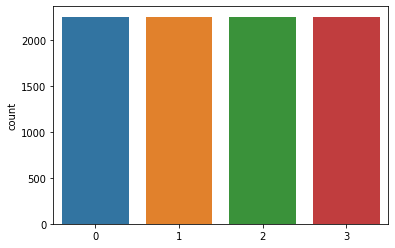

In [6]:
import seaborn as sns
sns.countplot(x = labels);
plt.show()

#### Shuffling and Splitting the Data

In [7]:
images, labels = shuffle(images, labels, random_state=10)

train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size = 0.4)
test_images, val_images, test_labels, val_labels = train_test_split(test_images, test_labels, test_size = 0.5)

In [8]:
del images

In [9]:
n_train = train_labels.shape[0]
n_val = val_labels.shape[0]
n_test = test_labels.shape[0]

print("Number of training examples: {}".format(n_train))
print("Number of validation examples: {}".format(n_val))
print("Number of testing examples: {}".format(n_test))

print("Training images are of shape: {}".format(train_images.shape))
print("Training labels are of shape: {}".format(train_labels.shape))
print("Validation images are of shape: {}".format(val_images.shape))
print("Validation labels are of shape: {}".format(val_labels.shape))
print("Test images are of shape: {}".format(test_images.shape))
print("Test labels are of shape: {}".format(test_labels.shape))

Number of training examples: 5400
Number of validation examples: 1800
Number of testing examples: 1800
Training images are of shape: (5400, 128, 128, 3)
Training labels are of shape: (5400,)
Validation images are of shape: (1800, 128, 128, 3)
Validation labels are of shape: (1800,)
Test images are of shape: (1800, 128, 128, 3)
Test labels are of shape: (1800,)


#### Normalizing the Image data

In [10]:
train_images = train_images / 255.0 
val_images = val_images / 255.0
test_images = test_images / 255.0

### Inception Model

In [15]:
model = keras.models.Sequential([
    keras.applications.inception_v3.InceptionV3(include_top=False, weights='imagenet', pooling='avg', input_shape=(128,128,3)),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(512),
    keras.layers.LeakyReLU(alpha=0.05),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(4, activation='softmax')
])

# Compling our Model
model.compile(optimizer=tf.optimizers.SGD(learning_rate=0.0075),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model._name="Inception_Classifier"
model.summary()
history = model.fit(train_images,
                    train_labels,
                    epochs=15, # Max no.of epochs
                    #steps_per_epoch=100,
                    batch_size=40, # size for parallel computation, higher require more GPU/CPU-RAM
                    validation_freq=1,
                    validation_data=(val_images,val_labels),
                 
                   )

Model: "Inception_Classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               1049088   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_5 (Dense)              (None, 4)        

2022-04-09 05:31:14.231951: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1061683200 exceeds 10% of free system memory.
2022-04-09 05:31:15.337865: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1061683200 exceeds 10% of free system memory.
2022-04-09 05:31:16.106053: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15


2022-04-09 05:31:22.253011: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


135/135 [==============================] - 26s 102ms/step - loss: 1.1113 - accuracy: 0.5111 - val_loss: 0.9418 - val_accuracy: 0.6122
Epoch 2/15
135/135 [==============================] - 12s 89ms/step - loss: 0.5891 - accuracy: 0.7807 - val_loss: 0.4943 - val_accuracy: 0.8167
Epoch 3/15
135/135 [==============================] - 12s 89ms/step - loss: 0.3831 - accuracy: 0.8698 - val_loss: 0.4100 - val_accuracy: 0.8572
Epoch 4/15
135/135 [==============================] - 12s 89ms/step - loss: 0.2502 - accuracy: 0.9163 - val_loss: 0.4847 - val_accuracy: 0.8494
Epoch 5/15
135/135 [==============================] - 12s 89ms/step - loss: 0.1715 - accuracy: 0.9411 - val_loss: 0.4247 - val_accuracy: 0.8772
Epoch 6/15
135/135 [==============================] - 12s 89ms/step - loss: 0.1419 - accuracy: 0.9507 - val_loss: 0.4981 - val_accuracy: 0.8544
Epoch 7/15
135/135 [==============================] - 12s 88ms/step - loss: 0.1011 - accuracy: 0.9667 - val_loss: 0.4259 - val_accuracy: 0.8756
Ep

### Evaluating the Model

#### Training & Validation Accuracy Loss Chart

In [16]:
def plot_accuracy_loss_chart(history):
    
    epochs = [i for i in range(15)]
    fig , ax = plt.subplots(1,2)
    
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    
    fig.set_size_inches(20,10)
    
    ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
    ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
    ax[0].set_title('Training & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")

    ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
    ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
    ax[1].set_title('Training & Validation Loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Training & Validation Loss")
    
    plt.show()

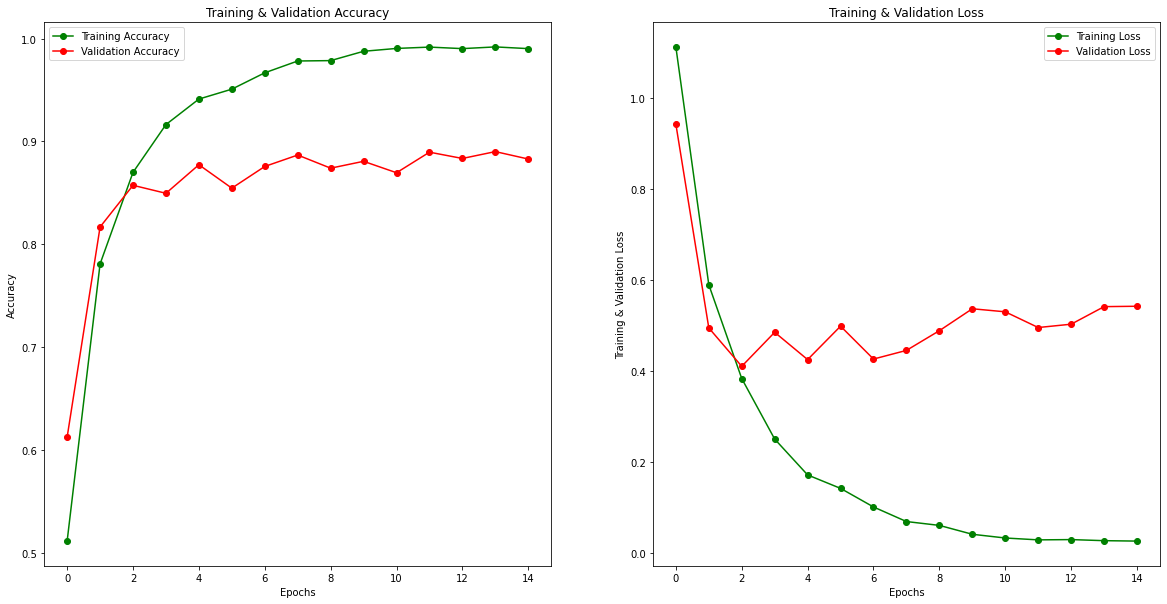

In [17]:
plot_accuracy_loss_chart(history)

#### Class-wise Accuracy

In [18]:
predictions = model.predict(test_images)
predictions = np.argmax(predictions,axis=1)

In [19]:
cm = confusion_matrix(test_labels, predictions)

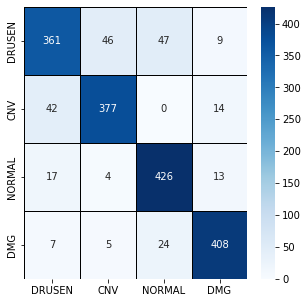

In [20]:
def plot_confusion_matrix (cm):
    plt.figure(figsize = (5,5))
    sns.heatmap(
        cm, 
        cmap = 'Blues', 
        linecolor = 'black', 
        linewidth = 1, 
        annot = True, 
        fmt = '', 
        xticklabels = class_names, 
        yticklabels = class_names)
    
plot_confusion_matrix(cm)

In [21]:
accuracy_score = {}

for i in range(len(cm)):
    accuracy_score[class_names[i]] = cm[i][i]/sum(cm[i])
    
accuracy_score

{'DRUSEN': 0.7796976241900648,
 'CNV': 0.8706697459584296,
 'NORMAL': 0.9260869565217391,
 'DMG': 0.918918918918919}

## VGG model

In [22]:
# Importing VGG-16 model from keras
from keras.applications.vgg16 import VGG16
vgg16_model = model1 = VGG16()
model1 = Sequential()

for layer in vgg16_model.layers[:-1]: # this is where I changed your code
    model1.add(layer)    

# Freeze the layers 
for layer in model1.layers:
    layer.trainable = True

# Add 'softmax' instead of earlier 'prediction' layer.
n_classes = 3
model1.add(Dense(n_classes, activation='softmax'))

# compiling the sequential model
model1.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

print(model1.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [25]:
history_CNN = model.fit(train_images,train_labels, batch_size=16, epochs=15, 
                         validation_data=(val_images, val_labels))

2022-04-09 05:38:54.368072: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1061683200 exceeds 10% of free system memory.


Epoch 1/15
338/338 [==============================] - 20s 59ms/step - loss: 0.1647 - accuracy: 0.9448 - val_loss: 0.5233 - val_accuracy: 0.8506
Epoch 2/15
338/338 [==============================] - 19s 57ms/step - loss: 0.1257 - accuracy: 0.9570 - val_loss: 0.4017 - val_accuracy: 0.8783
Epoch 3/15
338/338 [==============================] - 20s 59ms/step - loss: 0.0872 - accuracy: 0.9724 - val_loss: 0.4551 - val_accuracy: 0.8706
Epoch 4/15
338/338 [==============================] - 20s 59ms/step - loss: 0.0733 - accuracy: 0.9767 - val_loss: 0.4151 - val_accuracy: 0.8989
Epoch 5/15
338/338 [==============================] - 19s 56ms/step - loss: 0.0716 - accuracy: 0.9763 - val_loss: 0.6782 - val_accuracy: 0.8633
Epoch 6/15
338/338 [==============================] - 20s 58ms/step - loss: 0.0481 - accuracy: 0.9880 - val_loss: 0.4835 - val_accuracy: 0.9039
Epoch 7/15
338/338 [==============================] - 19s 56ms/step - loss: 0.0502 - accuracy: 0.9819 - val_loss: 0.4779 - val_accuracy:

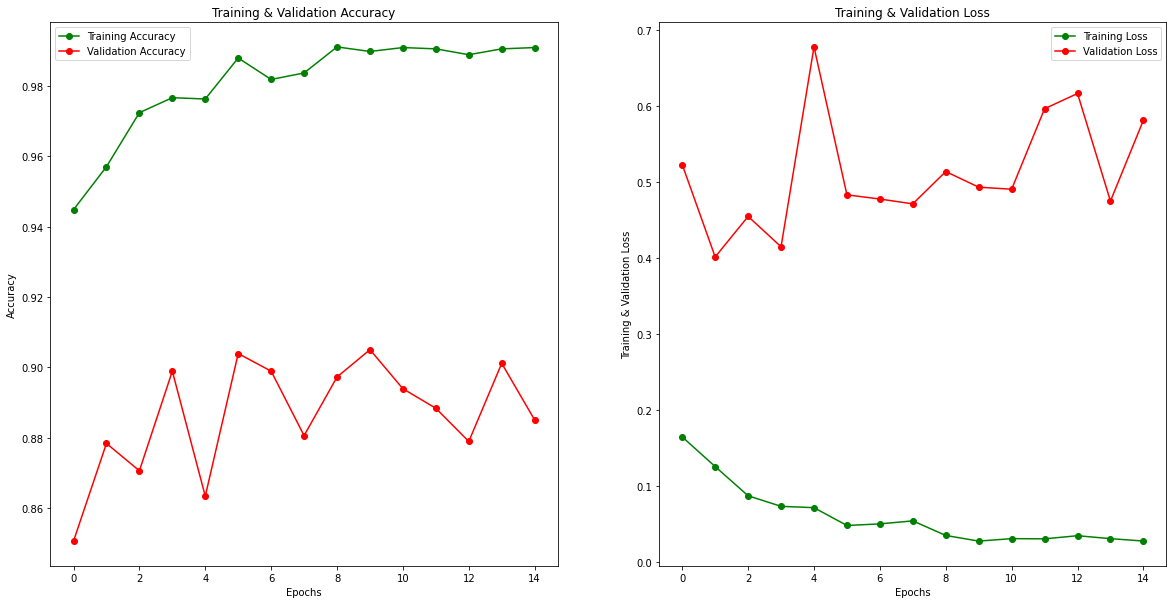

In [27]:
plot_accuracy_loss_chart(history_CNN)

In [30]:
vpredictions = model.predict(test_images)
vpredictions = np.argmax(vpredictions,axis=1)

In [31]:
mc = confusion_matrix(test_labels, vpredictions)

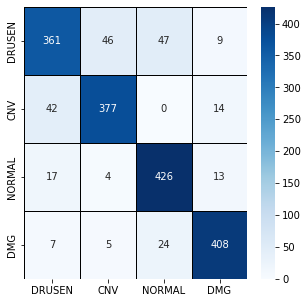

In [32]:
def plot_confusion_matrix (mc):
    plt.figure(figsize = (5,5))
    sns.heatmap(
        cm, 
        cmap = 'Blues', 
        linecolor = 'black', 
        linewidth = 1, 
        annot = True, 
        fmt = '', 
        xticklabels = class_names, 
        yticklabels = class_names)
    
plot_confusion_matrix(mc)

In [33]:
accuracy_score = {}

for i in range(len(mc)):
    accuracy_score[class_names[i]] = cm[i][i]/sum(cm[i])
    
accuracy_score

{'DRUSEN': 0.7796976241900648,
 'CNV': 0.8706697459584296,
 'NORMAL': 0.9260869565217391,
 'DMG': 0.918918918918919}

## Alexnet

In [34]:
# ALEXNET Architecture 
mmodel1 = keras.models.Sequential([
    keras.layers.Conv2D(filters = 96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters = 256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters = 384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters = 384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters = 256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(6, activation='softmax')])

In [35]:
from tensorflow.keras import optimizers
model1.compile(loss='sparse_categorical_crossentropy', optimizer = optimizers.Adam(learning_rate = 0.001), metrics=['accuracy'])
model1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_188 (Conv2D)          (None, 55, 55, 96)        11712     
_________________________________________________________________
batch_normalization_188 (Bat (None, 55, 55, 96)        384       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_189 (Conv2D)          (None, 27, 27, 256)       614656    
_________________________________________________________________
batch_normalization_189 (Bat (None, 27, 27, 256)       1024      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 13, 13, 256)       0         
_________________________________________________________________
conv2d_190 (Conv2D)          (None, 13, 13, 384)      

In [39]:
history1 = model.fit(train_images,train_labels, epochs = 15,   validation_data=(val_images, val_labels) , shuffle = True)

Epoch 1/15
169/169 [==============================] - 15s 87ms/step - loss: 0.0066 - accuracy: 0.9985 - val_loss: 0.4521 - val_accuracy: 0.9100
Epoch 2/15
169/169 [==============================] - 14s 81ms/step - loss: 0.0045 - accuracy: 0.9985 - val_loss: 0.4854 - val_accuracy: 0.9067
Epoch 3/15
169/169 [==============================] - 13s 79ms/step - loss: 0.0048 - accuracy: 0.9987 - val_loss: 0.4700 - val_accuracy: 0.9139
Epoch 4/15
169/169 [==============================] - 13s 79ms/step - loss: 0.0036 - accuracy: 0.9991 - val_loss: 0.4685 - val_accuracy: 0.9117
Epoch 5/15
169/169 [==============================] - 14s 85ms/step - loss: 0.0038 - accuracy: 0.9989 - val_loss: 0.4741 - val_accuracy: 0.9139
Epoch 6/15
169/169 [==============================] - 14s 80ms/step - loss: 0.0027 - accuracy: 0.9994 - val_loss: 0.4868 - val_accuracy: 0.9150
Epoch 7/15
169/169 [==============================] - 13s 79ms/step - loss: 0.0020 - accuracy: 0.9993 - val_loss: 0.4908 - val_accuracy:

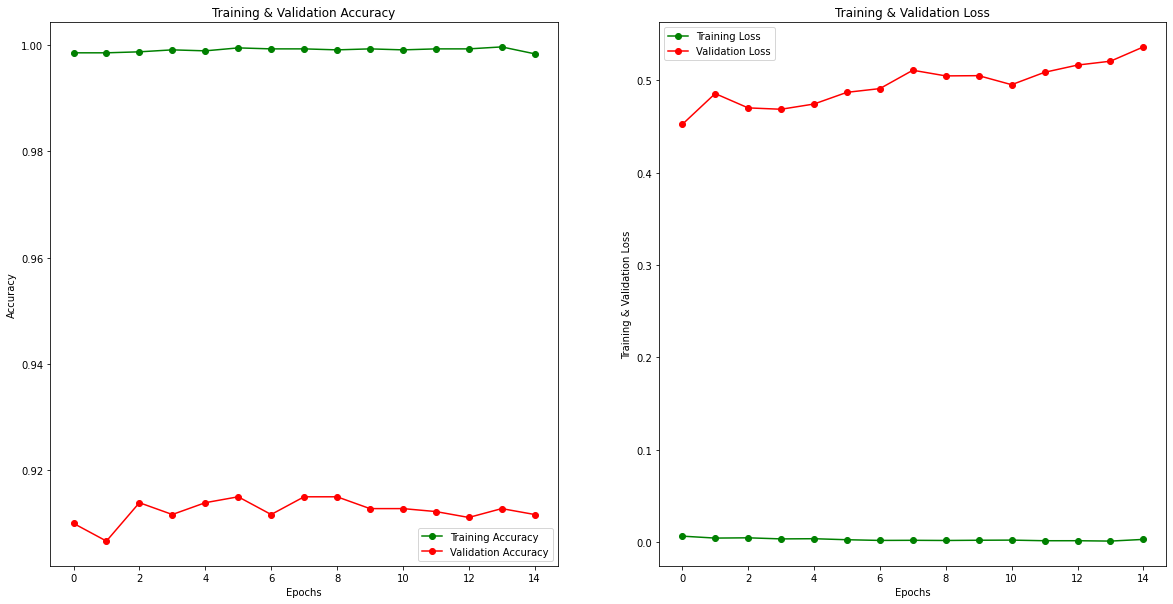

In [40]:
plot_accuracy_loss_chart(history1)

In [42]:
apredictions = model.predict(test_images)
apredictions = np.argmax(apredictions,axis=1)

In [44]:
mcc = confusion_matrix(test_labels, vpredictions)

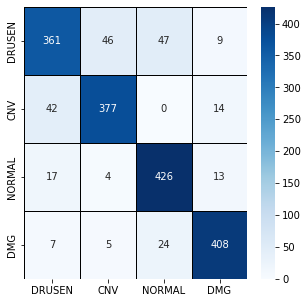

In [45]:
def plot_confusion_matrix (mcc):
    plt.figure(figsize = (5,5))
    sns.heatmap(
        cm, 
        cmap = 'Blues', 
        linecolor = 'black', 
        linewidth = 1, 
        annot = True, 
        fmt = '', 
        xticklabels = class_names, 
        yticklabels = class_names)
    
plot_confusion_matrix(mcc)

In [46]:
accuracy_score = {}

for i in range(len(mcc)):
    accuracy_score[class_names[i]] = cm[i][i]/sum(cm[i])
    
accuracy_score

{'DRUSEN': 0.7796976241900648,
 'CNV': 0.8706697459584296,
 'NORMAL': 0.9260869565217391,
 'DMG': 0.918918918918919}

## Transfer Learning ##

In [26]:
#Import Libraries
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

In [48]:
print("\n\nPrinting layers of Model -",model.name,":")
for layer in model.layers:
    print(layer)

print("\nFeature extraction from the model:")
feature_layer = model.get_layer('inception_v3')
print(feature_layer)



Printing layers of Model - Inception_Classifier :

Feature extraction from the model:


Inception Model Architecture


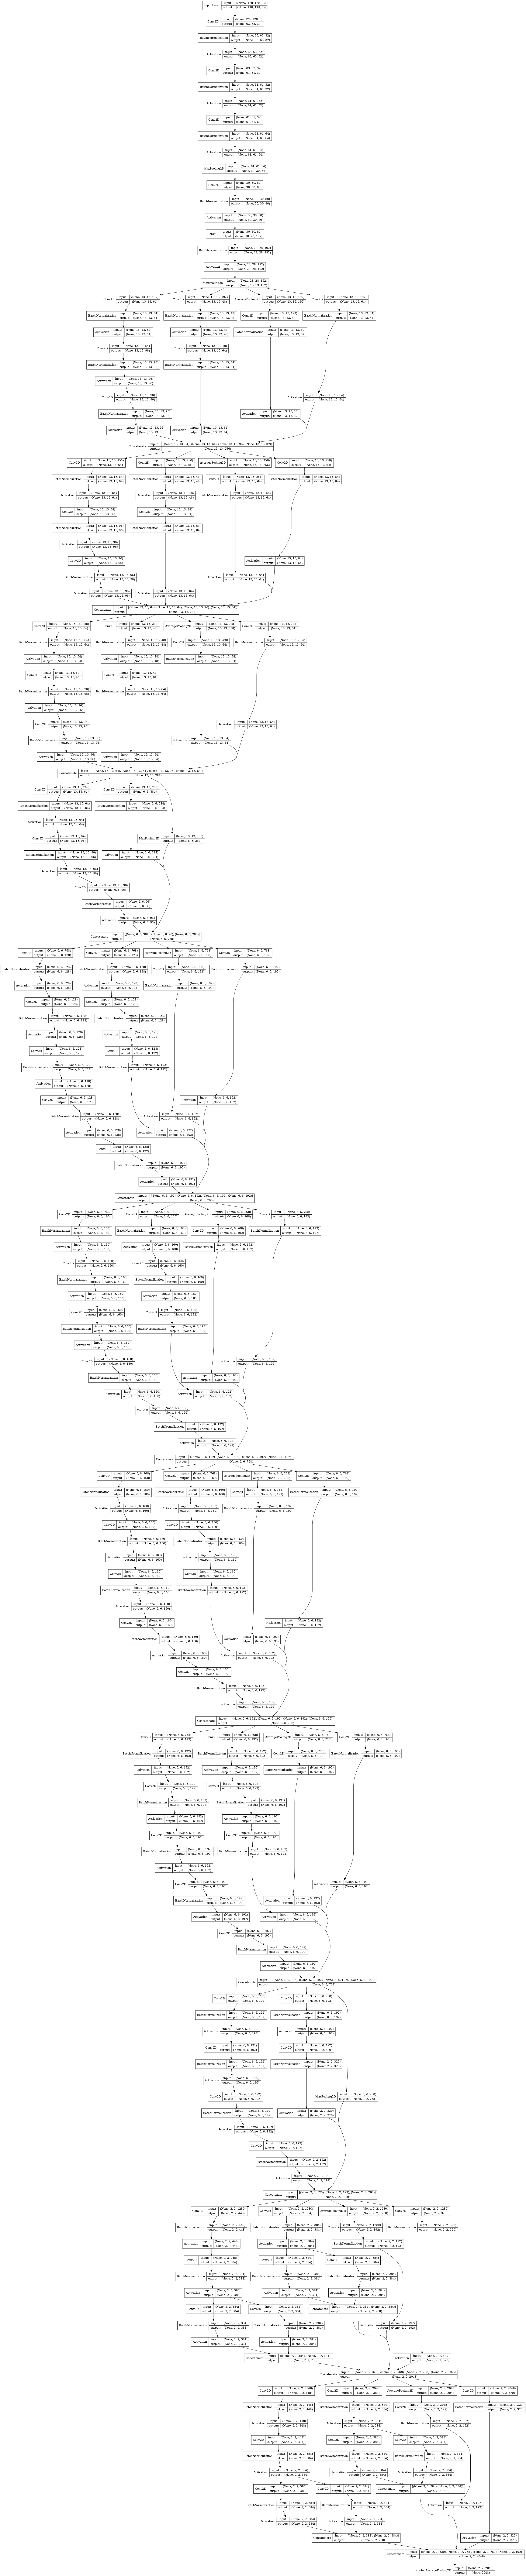

In [49]:
feature_model = keras.Model(inputs = feature_layer.inputs, outputs = feature_layer.outputs)
feature_model._name="Inception_Feature_Extractor"

# Showing Inception Model Architecture
print("Inception Model Architecture")
keras.utils.plot_model(feature_model,'Inception.png',show_shapes=True, show_layer_names=False, rankdir='TB', expand_nested=True, dpi=75)
# rankdir='TB' -> top to bottom
#feature_model.summary()

In [50]:
train_features = feature_model.predict(train_images)
test_features = feature_model.predict(test_images)
print("Training data size:", train_features.shape)
print("Test data size:", test_features.shape)

Training data size: (5400, 2048)
Test data size: (1800, 2048)


In [53]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

# keep no.of classifiers even for plottinf purposes
classifiers = [ GaussianNB(), DecisionTreeClassifier(),
               RandomForestClassifier(), KNeighborsClassifier(), SVC(kernel='linear')]



Classifier: GaussianNB()
Accuracy  is 87.83333333333333%, Report:
              precision    recall  f1-score   support

           0       0.85      0.84      0.84       463
           1       0.87      0.91      0.89       433
           2       0.90      0.84      0.87       460
           3       0.90      0.93      0.92       444

    accuracy                           0.88      1800
   macro avg       0.88      0.88      0.88      1800
weighted avg       0.88      0.88      0.88      1800



Classifier: DecisionTreeClassifier()
Accuracy  is 86.11111111111111%, Report:
              precision    recall  f1-score   support

           0       0.81      0.84      0.83       463
           1       0.88      0.85      0.87       433
           2       0.86      0.87      0.87       460
           3       0.89      0.87      0.88       444

    accuracy                           0.86      1800
   macro avg       0.86      0.86      0.86      1800
weighted avg       0.86      0.86    

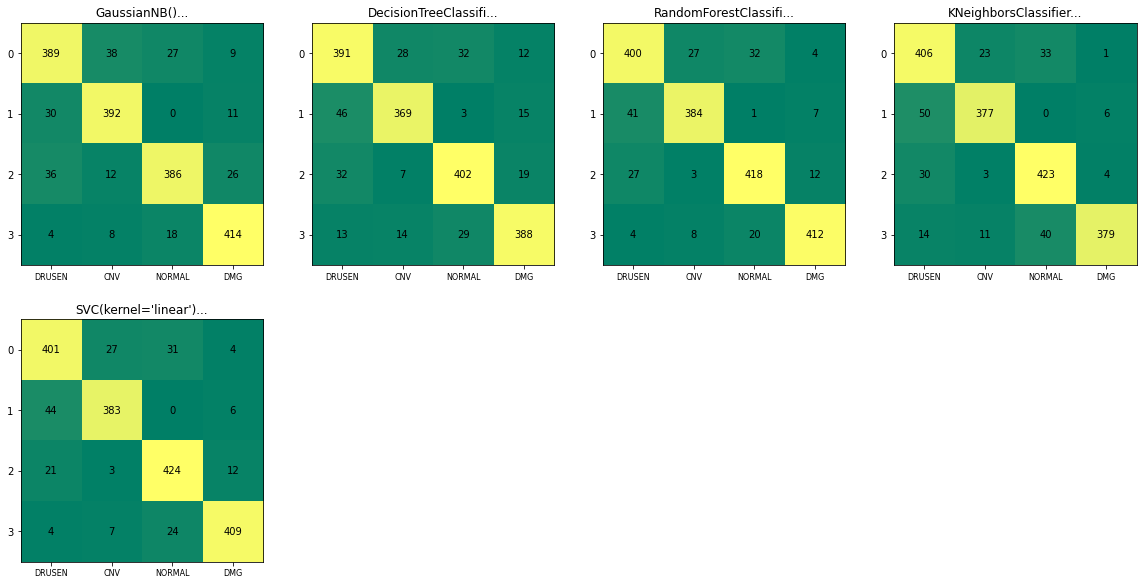

In [54]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

fig = plt.figure(figsize=(20,10))
fig.tight_layout()
nof_clsfrs = len(classifiers)
Accuracies = {}


for i in range(nof_clsfrs):
    tf.keras.backend.clear_session
    classifier = classifiers[i]
    plt.subplot(2,4,i+1)
    plt.xticks([])
    plt.yticks([])
    
    print(f'\n\nClassifier: {str(classifier)}')
    classifier.fit(train_features, train_labels)
    test_pred = classifier.predict(test_features)
    
    acc = accuracy_score(test_labels,test_pred) *100
    Accuracies[str(classifier)[0:20]+'...'] = acc
    print(f'Accuracy  is {acc}%, Report:')
    print(classification_report(test_labels, test_pred))
    
    plt.gca().set_title(str(classifier)[0:20]+'...')
    CM = confusion_matrix(test_labels, test_pred)
    plt.imshow(CM,interpolation='nearest',cmap='summer')
    for (i, j), z in np.ndenumerate(CM):
        plt.text(j, i, z, ha='center', va='center')
    plt.xticks(np.arange(len(class_names)),class_names, fontsize=8)
    plt.yticks(np.arange(len(class_names)))
    plt.grid(False)
plt.show()

In [55]:
import pandas as pd
result = pd.DataFrame({'Classifier':list(Accuracies.keys()),
                 'Accuracy':list(Accuracies.values())})
print("Results:")
print(result)
print("\n\nClassifier for which max Accuracy is obtained:")
print(result.iloc[result["Accuracy"].idxmax()])

Results:
                Classifier   Accuracy
0          GaussianNB()...  87.833333
1  DecisionTreeClassifi...  86.111111
2  RandomForestClassifi...  89.666667
3  KNeighborsClassifier...  88.055556
4  SVC(kernel='linear')...  89.833333


Classifier for which max Accuracy is obtained:
Classifier    SVC(kernel='linear')...
Accuracy                    89.833333
Name: 4, dtype: object
